### Fine-tuning for Classification

We will learn to fine-tune the LLM on a specific task - classifying text into "spam" or "not spam". The kind of fine-tuning requires less data and compute power than instruction fine-tuning, however it is confined to the specific classes on which the model has been trained. 

We start by preparing the dataset.

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
              f"and extraction.")
        return

    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


In [2]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Class label distribution
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


For simplicity and because we want a smaller dataset (to speed up finetuning of the LLM), we choose to undersample the dataset to include 747 instances of each class. 

In [4]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=42
    )
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
# Convert labels to integers
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [7]:
# Split the dataset into three parts - 70% train, 10% validation, 20% testing
def random_split(df, train_frac, valid_frac):

    df = df.sample(
        frac=1, random_state=42
    ).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    valid_end = train_end + int(len(df) * valid_frac)

    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]

    return train_df, valid_df, test_df

train_df, valid_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [9]:
# Save the datasets to re-use later
train_df.to_parquet("train.parquet", index=None)
valid_df.to_parquet("valid.parquet", index=None)
test_df.to_parquet("test.parquet", index=None)

In [1]:
import pandas as pd
train_df = pd.read_parquet("Datasets/train.parquet")
valid_df = pd.read_parquet("Datasets/valid.parquet")
test_df = pd.read_parquet("Datasets/test.parquet")

#### Creating data loaders

Previously, we utilised a sliding window technique to generate uniformly sized text chunks, which we then grouped into batches for more efficient model training. Each chunk functioned as an individual training instance. However, we are now working with a spam dataset that contains messages of varying lengths. To batch these messages, we have two primary options:
- Truncate all messages to the length of the smallest message in the dataset/batch.
- Pad all messages to the length of the longest message in the dataset/batch.

The first options is computationally cheaper but may result in significant information loss if shorter messages are much shorter than average, potentially reducing model performance. So, we opt for option two, which preserves the entire content of all messages. We will use "<|endoftext|>" as a padding token. Instead of appending this string to each of the text messages directly, we add the token ID corresponding to it to the encoded text messages. 

In [2]:
import tiktoken
tokeniser = tiktoken.get_encoding("gpt2")
print(tokeniser.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


We first need to implement a PyTorch Dataset, which specifies how the data is loaded and processed before we can instantiate the data loaders. This "SpamDataset" class will handle several key tasks: it identifies the longest sequences in the training dataset, encodes the text messages, and ensures that all other sequences are padded with a <i>padding token</i> to match the length of the longest sequence.

In [3]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, parquet_file, tokeniser, max_length=None,
                 pad_token_id=50_256):
        self.data = pd.read_parquet(parquet_file)

        self.encoded_texts = [
            tokeniser.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [
            encoded_text + [pad_token_id] * 
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [4]:
train_dataset = SpamDataset(
    parquet_file="Datasets/train.parquet",
    max_length=None,
    tokeniser=tokeniser
)
print(train_dataset.max_length)

109


The longest sequence in the training data is 109 tokens. The model can handle sequences of up to 1,024 tokens, given its context length limit. If the dataset includes longer text, we can pass max_length=1,024 to ensure the data doesn't exceed the model's supported input context length. 

Next, we pad the validation and test sets to match the length of the longest training sequence. Any samples longer will be truncated using <i>encoded_text[:self.max_length]</i>. This truncation is optional; you can set max_length = None as well. 

In [5]:
val_dataset = SpamDataset(
    parquet_file="Datasets/valid.parquet",
    max_length=train_dataset.max_length,
    tokeniser=tokeniser
)

test_dataset = SpamDataset(
    parquet_file="Datasets/test.parquet",
    max_length=train_dataset.max_length,
    tokeniser=tokeniser
)

We can instantiate data loaders similarly to as before. However, in this case the targets represent class labels rather than the next token in the text. If we choose a batch of 8, each batch will consist of eight training examples of length 109 and the corresponding class label of each example. 

In [6]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(42)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [7]:
# Ensure data loaders are working
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Target batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 109])
Target batch dimensions: torch.Size([8])


In [8]:
# Get an idea of the dataset size
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


#### Initialising a model with pretrained weights

In [9]:
from Chapter05 import model_configs

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

In [ ]:
from gpt_download import download_and_load_gpt2
from Chapter04 import GPTModel
from Chapter05 import load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

In [12]:
from Chapter04 import generate_text_simple
from Chapter05 import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokeniser),
    max_new_tokens=20,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokeniser))

Every effort moves you to the point of the "I-don-it-from-the-battles-


Still not convinced the model weights have been loaded correctly as the model is not generating coherent text.

Before fine-tuning the model as a spam classifier, let's see whether the model already classifies spam messages by prompting it with instructions.

In [15]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no': "
    "'You are a winner you have been specially "
    "selected to receive £1000 cash or a £2000 reward.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokeniser),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokeniser))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive £1000 cash or a £2000 reward.'

'Theresa May has been a victim of the Tory party's 'big, bad and nasty' Brexit.



No, the model cannot follow instructions - it has only undergone pretraining and lacks instruction fine-tuning. So, we must prepare the model for classification fine-tuning. 

#### Adding a classification head

We must replace the original output layer, which maps the hidden representation to a vocabulary of size 50,257, with a smaller output layer that maps to two classes: 0 (not spam) or 1 (spam).

Since we start with a pretrained model, it is not necessary to fine-tune all model layers. In LLMs, the lower layers generally capture basic language structures and semantics applicable across a wide range of tasks and datasets. So, fine-tuning only the last layers (nearer the output), which are more specific to nuanced linguistic patterns and task-specific features, is often sufficient to adapt the model to new tasks. It is also more computationally efficient. 

In [16]:
# First we freeze the model - make all layers non-trainable
for param in model.parameters():
    param.requires_grad = False 

In [17]:
# Replace the output layer
torch.manual_seed(42)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

The new model.out_head output layer has its requires_grad attribute set to True by default, so it's the only layer that will be updated during training. This should be sufficient for this exercise, although fine-tuning additional layers can noticeably improve the predictive performance of the model. 

We also configure the last transformer block and the final LayerNorm module, which connects this block to the output layer, to be trainable.

In [18]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

Even though we added a new output layer and marked certain layers as trainable or not, we can still use this model similarly to before, i.e. we can feed it an example text. 

In [19]:
# Encode the inputs
inputs = tokeniser.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [20]:
# Pass encoded token IDs to the model
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[0.7508, 1.1412],
         [2.5311, 8.2153],
         [2.3031, 6.8461],
         [3.7813, 5.9733]]])
Outputs dimensions: torch.Size([1, 4, 2])


Now the size is [1, 4, 2] rather than [1, 4, 50_257] since we replaced the output layer of the model. 

Remember that we are interested in fine-tuning this model to return a class label. We only need to fine-tune the last output token. Below is that last output token, which we still need to convert into a class-label prediction. 

In [21]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[3.7813, 5.9733]])


#### Calculating the classification loss and accuracy

We must implement the model evaluation functions used during fine-tuning. We previously computed the token ID of the next token generated by the LLM by converting the 50,257 outputs into probabilities via the softmax function, and then returning the position of the highest probability via the argmax function. We take the same approach here, except we work in 2-dimensions.

In [22]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label: ", label.item())

Class label:  1


In the case above, the model predicts the input text is spam. Using the softmax function here is optional because the largest outputs directly correspond to the highest probability scores. So we can simplify the code as below.

In [23]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label: ", label.item())

Class label:  1


In [24]:
# Determine classification accuracy by applying the prediction to all examples in the dataset
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )

        else:
            break
    
    return correct_predictions / num_examples

Let's use the function to determine the classification accuracies across various datasets estimated from 10 batches.

In [25]:
device = torch.device("cpu")
model.to(device)

torch.manual_seed(42)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 50.00%
Validation accuracy: 53.75%
Test accuracy: 58.75%


As we can see, the prediction accuracies are near a random prediction. To improve this, we need to fine-tune the model. We must first define the loss function to optimise during training. As classification accuracy is not a differentiable function, we use cross-entropy loss as a proxy to maximise accuracy. The calc_loss_batch function remains the same except for optimising only the last token rather than all tokens. 

In [28]:
def calc_loss_batch_class(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # logits of last output token
    loss = torch.nn.functional.cross_entropy(
        logits, target_batch
    )
    return loss

In [29]:
# Remains the same
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # iterate over all batches if no fixed batch size given
    else:
        num_batches = min(num_batches, len(data_loader)) 
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch_class(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item() # sum loss for each batch
        else:
            break
    return total_loss / num_batches # average the loss over all the batches

Similar to calculating the training accuracy, we now compute the initial loss for each data set. 

In [31]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.755
Validation loss: 0.773
Test loss: 0.671


#### Fine-tuning the model on supervised data

We must define and use the training function to fine-tune the pretrained LLM and improve its spam classification accuracy. The function below is the same as before with two differences: we now track the number of training examples seen (examples_seen) instead of the number of tokens, and we calculate the accuracy after each epoch instead of printing a sample text.

In [32]:
def train_classifier_simple(model, train_loader, val_loader,
                            optimiser, device, num_epochs,
                            eval_freq, eval_iter):
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs): # step 1
        model.train()

        for input_batch, target_batch in train_loader: # step 2
            optimiser.zero_grad() # step 3
            loss = calc_loss_batch_class( # step 4
                input_batch, target_batch, model, device
            )
            loss.backward() # step 5
            optimiser.step() # step 6
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0: # step 7
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [33]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropout is disabled for stable, reproducible results
    with torch.no_grad(): # disables gradient tracking
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [34]:
import time

start_time = time.time()
torch.manual_seed(42)
optimiser = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimiser, device,
        num_epochs=num_epochs, eval_freq=50, eval_iter=5
    )

end_time = time.time()
execution_time_mins = (end_time - start_time) / 60
print(f"Training completed in {execution_time_mins:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 0.788, Val loss 0.740
Epoch 1 (Step 000050): Train loss 0.769, Val loss 0.726
Epoch 1 (Step 000100): Train loss 0.599, Val loss 0.607
Training accuracy: 95.00% | Validation accuracy: 87.50%
Epoch 2 (Step 000150): Train loss 0.453, Val loss 0.460
Epoch 2 (Step 000200): Train loss 0.324, Val loss 0.339
Epoch 2 (Step 000250): Train loss 0.565, Val loss 0.360
Training accuracy: 85.00% | Validation accuracy: 92.50%
Epoch 3 (Step 000300): Train loss 0.284, Val loss 0.315
Epoch 3 (Step 000350): Train loss 0.198, Val loss 0.291
Training accuracy: 77.50% | Validation accuracy: 85.00%
Epoch 4 (Step 000400): Train loss 0.428, Val loss 0.381
Epoch 4 (Step 000450): Train loss 0.221, Val loss 0.289
Epoch 4 (Step 000500): Train loss 0.255, Val loss 0.326
Training accuracy: 92.50% | Validation accuracy: 92.50%
Epoch 5 (Step 000550): Train loss 0.275, Val loss 0.303
Epoch 5 (Step 000600): Train loss 0.325, Val loss 0.308
Training accuracy: 80.00% | Validation accuracy:

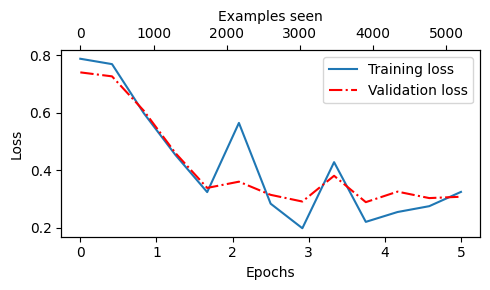

In [37]:
# Plot
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}", color='r'
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plt.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

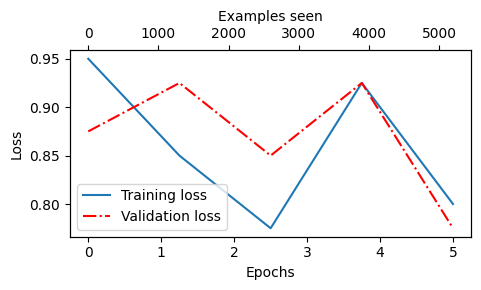

In [38]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(val_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs)

In [39]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 82.40%
Validation accuracy: 75.84%
Test accuracy: 84.67%


Far better than random predictions, but odd results. Test performance is better than training and validation? Model may be slightly underfit.

#### Using the model as a spam classifier

In [40]:
def classify_review(
        text, model, tokeniser, device, max_length=None,
        pad_token_id=50_256):
    model.eval()

    input_ids = tokeniser.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(
        max_length, supported_context_length
    )]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [42]:
text_1 = "Congrats! You are a winner of a £1000 reward."
print(classify_review(
    text_1, model, tokeniser, device, max_length=train_dataset.max_length
))

not spam


In [43]:
text_2 = "Hey, are we still on for dinner tonight? Let me know!"
print(classify_review(
    text_2, model, tokeniser, device, max_length=train_dataset.max_length
))

not spam


Not looking great at the moment.

In [ ]:
# Save model
torch.save(model.state_dict(), "review_classifier.pth")

In [ ]:
# Load the model
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)